In [217]:
import cv2
import librosa
import mediapipe as mp
import numpy as np
from scipy.signal import resample
from sklearn.preprocessing import StandardScaler
from scipy.linalg import svd
import matplotlib.pyplot as plt
import math
import subprocess
import os
from sklearn.cross_decomposition import CCA
from scipy.stats import pearsonr

In [259]:
# Step 1: Load Video and Extract Audio
def extract_audio_from_video(video_path, audio_path="audio"):
    # Extract video name (without extension)
    video_name = os.path.splitext(os.path.basename(video_path))[0]
    # Define the audio file name with the same base name as the video
    audio_path = os.path.join(audio_path, f"{video_name}.wav")
    # Check if the audio file already exists
    if os.path.exists(audio_path):
        print(f"Audio file already exists: {audio_path}")
        return audio_path
    command = [
        'ffmpeg', '-i', video_path, '-vn', '-acodec', 'pcm_s16le', '-ar', '44100', '-ac', '2', audio_path
    ]
    subprocess.run(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    return audio_path

# Step 2: Extract Audio Features
def extract_audio_features(audio_path):
    """Extracts MFCC features from the audio."""
    y, sr = librosa.load(audio_path, sr=None)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)  # Shape: (13, n_frames)
    return mfccs.T  # Transpose to have frames along rows

# Step 3: Extract Lip Movement Features
def extract_lip_features(video_path):
    """Extracts lip landmarks from the video using MediaPipe."""
    mp_face_mesh = mp.solutions.face_mesh
    face_mesh = mp_face_mesh.FaceMesh(static_image_mode=False)
    cap = cv2.VideoCapture(video_path)
    upper_lip_points = [185,40,39,37,0,267,269,270,409]
    lower_lip_points = [146,91,181,84,17,314,405,321,375]
    face_width_points = [93,323]
    lip_features = []
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = face_mesh.process(frame_rgb)
        if results.multi_face_landmarks:
            for landmarks in results.multi_face_landmarks:           
                face_width = math.sqrt((landmarks.landmark[323].x - landmarks.landmark[93].x)**2 + (landmarks.landmark[323].y - landmarks.landmark[93].y)**2)
                upper_lips = [(lm.x, lm.y) for i, lm in enumerate(landmarks.landmark) if i in upper_lip_points]
                lower_lips = [(lm.x, lm.y) for i, lm in enumerate(landmarks.landmark) if i in lower_lip_points]
                distances = [math.sqrt((ul[0] - ll[0])**2 + (ul[1] - ll[1])**2) / face_width for ul, ll in zip(upper_lips, lower_lips)]                            
                lip_features.append(np.array(distances))  # Append the list of distances for each frame to lip_features (a list of distances)            
    cap.release()
    return np.array(lip_features)

# Step 4: Align and Normalize Features
def align_and_normalize_features(audio_features, video_features):
    """Aligns audio and video features by resampling and normalizing."""
    n_video_frames = video_features.shape[0]
    aligned_audio_features = resample(audio_features, n_video_frames)
    
    scaler = StandardScaler()
    aligned_audio_features = scaler.fit_transform(aligned_audio_features)
    video_features = scaler.fit_transform(video_features)
    return aligned_audio_features, video_features

# Step 2: Compute correlation coefficients for various audio shifts
def compute_correlation(audio_features, video_features, max_shift):
    cca = CCA(n_components=1)
    correlations = []
    
    for shift in range(-max_shift, max_shift + 1):
        # Shift audio features
        shifted_audio = np.roll(audio_features, shift, axis=0)
        
        # Ensure same length
        min_length = min(len(shifted_audio), len(video_features))
        shifted_audio = shifted_audio[:min_length]
        video_features = video_features[:min_length]
        
        # Perform CCA and get correlation coefficient
        cca.fit(shifted_audio, video_features)
        X_c, Y_c = cca.transform(shifted_audio, video_features)
        correlation = np.corrcoef(X_c.T, Y_c.T)[0, 1]
        correlations.append(correlation)    
    return np.array(correlations)

# Step 3: Compute liveness score
def compute_liveness_score(correlations, max_shift):
    p_ref = max(correlations[:max_shift])  # Max correlation at small negative shifts
    mean_corr = np.mean(correlations)
    sum_high_corr = np.sum(correlations[:2 * max_shift + 1])  # Around central peak
    
    L = (sum_high_corr / (2 * max_shift + 1)) * ((p_ref / mean_corr) - 1)
    return L
# Step 5: Perform Co-Inertia Analysis
def perform_coia(audio_features, video_features):
    """Performs Co-Inertia Analysis and returns the co-inertia score."""
    cross_covariance = np.dot(audio_features.T, video_features)
    _, singular_values, _ = svd(cross_covariance)
    co_inertia_score = np.sum(singular_values)
    return co_inertia_score
def calculate_L(p_hat, D):
    """
    Calculates the value of L based on the given equation.

    Args:
        p_hat: A numpy array representing the estimated probability values.
        D: The value of D for the calculation.

    Returns:
        The calculated value of L.
    """

    # Calculate p_ref
    p_ref = np.max(p_hat)

    # Calculate f(p_hat, i)
    f_p_hat = np.where(p_hat <= p_ref, 1, 0)

    # Calculate the sum of f(p_hat, i)
    sum_f_p_hat = np.sum(f_p_hat)

    # Calculate mean(p_hat)
    mean_p_hat = np.mean(p_hat)

    # Calculate L
    L = (sum_f_p_hat / (2 * D + 1)) * ((p_ref / mean_p_hat) - 1)

    return L

# Step 6: Main Function for Liveness Detection
def detect_liveness(video_path, threshold=0.5):
    """Main function to detect liveness using COIA."""
    # Extract audio from video
    print("[INFO] Extracting audio...")
    audio_path = extract_audio_from_video(video_path)
    
    # Extract audio features
    print("[INFO] Extracting audio features...")
    audio_features = extract_audio_features(audio_path)
    
    # Extract lip movement features
    print("[INFO] Extracting lip movement features...")
    lip_features = extract_lip_features(video_path)
    
    # Align and normalize features
    print("[INFO] Aligning and normalizing features...")
    aligned_audio, aligned_video = align_and_normalize_features(audio_features, lip_features)
    
    # Perform Co-Inertia Analysis
    # print("[INFO] Performing Co-Inertia Analysis...")
    # co_inertia_score = perform_coia(aligned_audio, aligned_video)
    # print(f"[INFO] Co-Inertia Score: {co_inertia_score}")
    #L = calculate_L(co_inertia_score,10)
    #print(f"[INFO] Threshold: {L}")
    # Perform Correlation Analysis
    print("[INFO] Performing Correlation Analysis...")
    correlations = compute_correlation(aligned_audio, aligned_video, max_shift=10)
    print('corr:',correlations)
    #liveness_score = compute_liveness_score(correlations, max_shift=20)
    liveness_score = calculate_L(correlations,10)
    print(f"[INFO] Liveness Score: {liveness_score}")
    
    # Classify based on the threshold
    if liveness_score > threshold:
        print("[RESULT] Live (Synchronized)")
    else:
        print("[RESULT] Fake (Desynchronized)")
    return correlations

In [68]:
video_path = "video/fake3.mp4"
correlations = detect_liveness(video_path)

[INFO] Extracting audio...
Audio file already exists: audio\fake3.wav
[INFO] Extracting audio features...
[INFO] Extracting lip movement features...
[INFO] Aligning and normalizing features...
[INFO] Performing Correlation Analysis...
corr: [0.83433198 0.84094578 0.81378724 0.7896705  0.75793724 0.70619586
 0.72345327 0.76463344 0.76668265 0.80918065 0.82341987 0.83621816
 0.77582343 0.80634398 0.7960664  0.78158761 0.81042114 0.774811
 0.75709669 0.7858017  0.8033087 ]
[INFO] Liveness Score: 0.06656376513289475
[RESULT] Fake (Desynchronized)


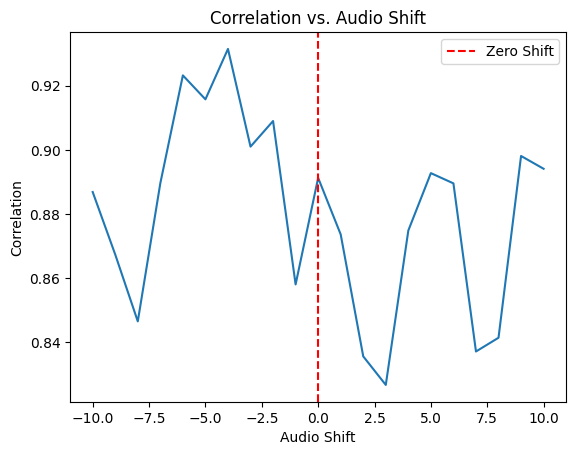

In [65]:
import matplotlib.pyplot as plt

# Plot correlations across shifts
def visualize_correlations(correlations, max_shift):
    shifts = range(-max_shift, max_shift + 1)
    plt.plot(shifts, correlations)
    plt.xlabel("Audio Shift")
    plt.ylabel("Correlation")
    plt.title("Correlation vs. Audio Shift")
    plt.axvline(0, color='red', linestyle='--', label="Zero Shift")
    plt.legend()
    plt.show()

# Call this function after computing correlations
visualize_correlations(correlations, max_shift=10)


In [177]:
def get_audio_energy(video_path):
    # Load audio using librosa
    y, sr = librosa.load(video_path, sr=16000, mono=True)
    
    # Get video frame rate using OpenCV
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)  # Frames per second
    cap.release()
    
    # Calculate hop_length and frame_length to match video frames
    hop_length = int(sr / fps)  # Hop length to match video frame rate
    frame_length = int(sr * 0.05)  # 50ms window (can be adjusted)
    
    # Calculate short-time energy
    energy = np.array([
        sum(abs(y[i:i+frame_length])**2)
        for i in range(0, len(y), hop_length)
    ])
    
    return energy,fps

In [178]:
# Min-max normalization function
def min_max_normalize(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

In [229]:
def moving_average(data, window_size):
    """
    Apply a moving average filter to smooth the input data while keeping the length the same.

    Parameters:
        data (numpy array): The input 1D array of data.
        window_size (int): The size of the moving average window.

    Returns:
        numpy array: The smoothed data with the same length as the input.
    """
    # Ensure the window size is odd
    if window_size % 2 == 0:
        raise ValueError("Window size must be odd to maintain symmetry.")
    
    # Create a window of ones and normalize it
    window = np.ones(window_size) / window_size
    
    # Pad the data to handle edges
    pad_size = window_size // 2
    padded_data = np.pad(data, (pad_size, pad_size), mode='edge')  # Reflect padding
    
    # Apply convolution to compute the moving average
    smoothed_data = np.convolve(padded_data, window, mode='valid')
    
    return smoothed_data

In [243]:
from scipy.stats import spearmanr

C:\Users\aanki\AppData\Local\Temp\ipykernel_18108\3755088403.py:3: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(video_path, sr=16000, mono=True)


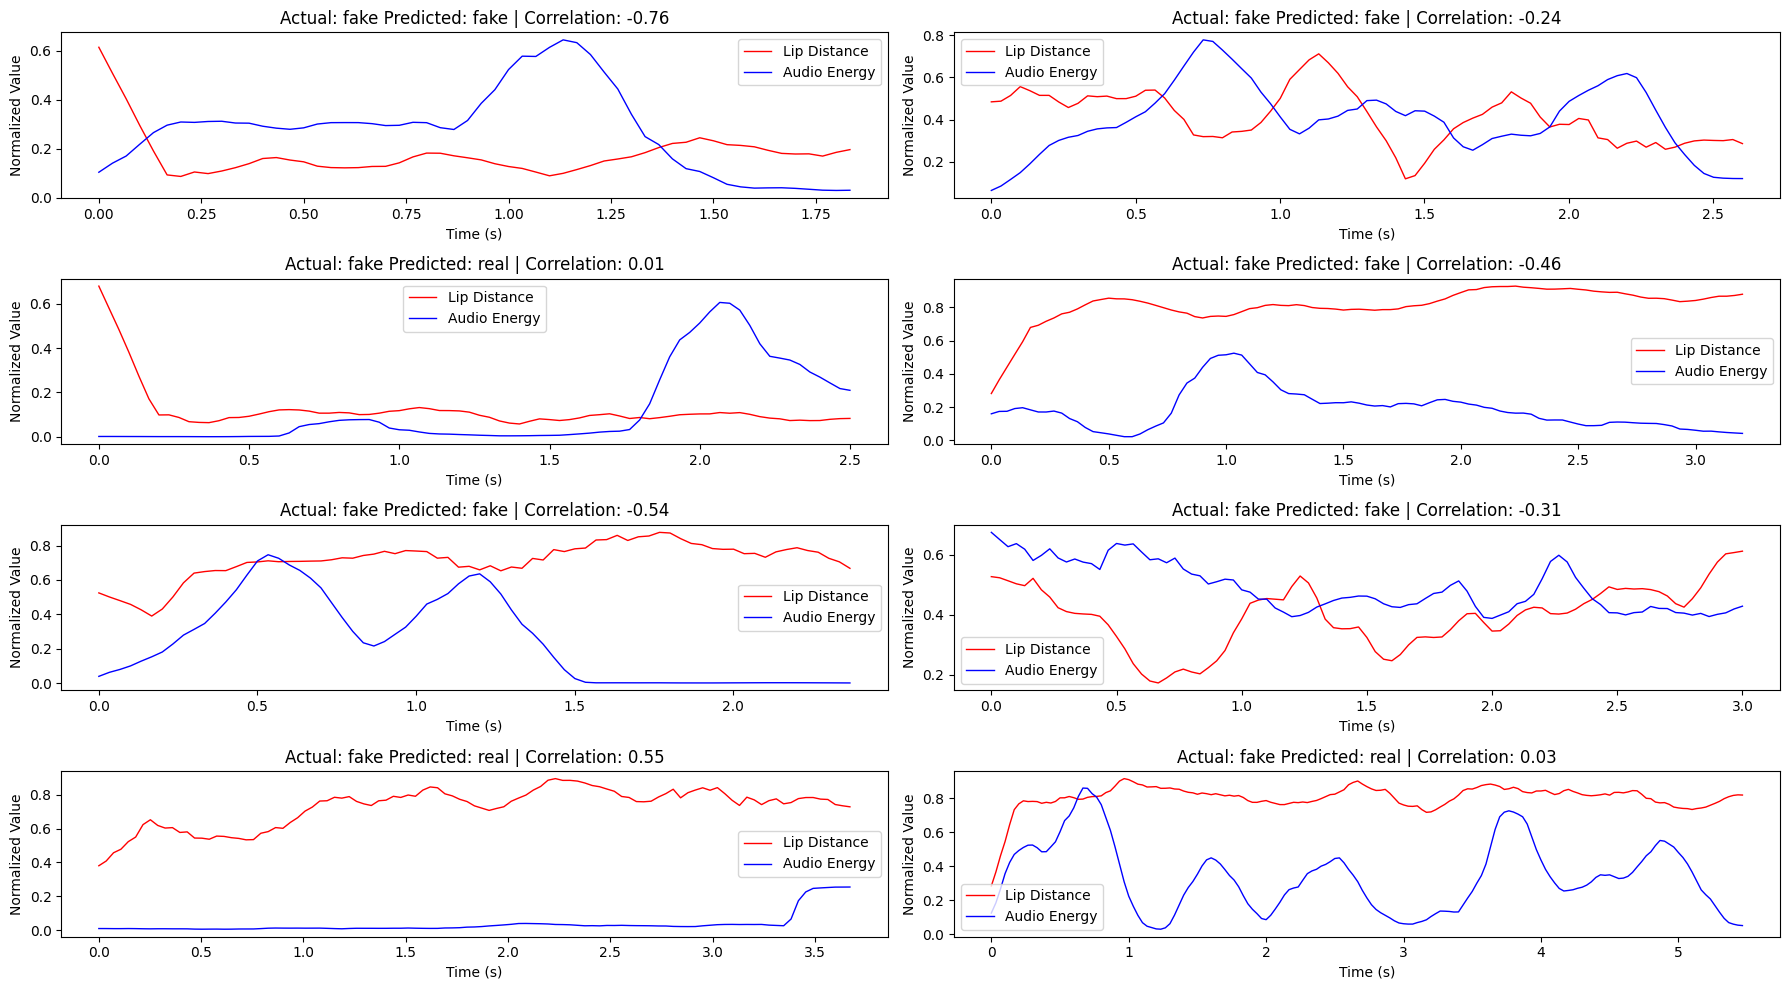

In [272]:
test = 'fake'
window_size = 9
video_paths = os.listdir(f'video/{test}')
num_plots = len(video_paths)
# Calculate the grid size (rows, columns)
ncols = 2  # For example, we want 3 columns
nrows = math.ceil(num_plots / ncols)  # Use ceiling to make sure all plots fit

# Create subplots with the calculated grid size
fig, axes = plt.subplots(nrows, ncols, figsize=(18, 10))

# Flatten the axes array to make indexing easier (in case of 2D array of axes)
axes = axes.flatten()
for index,video_path in enumerate(video_paths):
    video_path = f'video/{test}/{video_path}'
    # For Audio
    audio_energy,fps= get_audio_energy(video_path)

    # For Video
    lip_feat = extract_lip_features(video_path)
    mean_dist = np.sum(lip_feat,axis=1)
    min_len = min(len(mean_dist),len(audio_energy))
    normalized_dist = min_max_normalize(mean_dist)[:min_len]
    normalized_audio = min_max_normalize(audio_energy)[:min_len]
    times = np.arange(min_len) / fps
    avg_dist = moving_average(normalized_dist, window_size)
    avg_audio = moving_average(normalized_audio, window_size)

    # Calculate Pearson correlation coefficient
    correlation, _ = spearmanr(avg_dist, avg_audio)    
    pred = 'real' if correlation > 0 else 'fake'
    axes[index].set_title(f"Actual: {test} Predicted: {pred} | Correlation: {correlation:.2f}")
    axes[index].plot(times, avg_dist, label = "Lip Distance", color ='red',linewidth=1)
    axes[index].plot(times, avg_audio, label="Audio Energy", color='blue', linewidth=1)
    axes[index].legend()
    axes[index].set_xlabel('Time (s)')
    axes[index].set_ylabel('Normalized Value')    
plt.tight_layout()